# Car Price prediction

In this project, we will create a car price prediction model. The dataset was created by web-scraping a car sales portal - otomoto.pl. Previously, an exploratory analysis was performed.

###### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
import transformers
import visualize as vs

from sklearn import set_config
set_config(display='diagram')

# Get the Data
The data was gathered by web-scraping the otomoto.pl portal.

In [2]:
raw_data = pd.read_csv('otomoto_data.csv')
raw_data.head()

/home/damian/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (46,56) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Unnamed: 0,id,Price,Oferta od,Kategoria,Marka pojazdu,Model pojazdu,Wersja,Rok produkcji,Przebieg,...,Wartość wykupu,Uszkodzony,lub do (przebieg km),Tuning,Gwarancja dealerska (w cenie),Kierownica po prawej (Anglik),Homologacja ciężarowa,Zarejestrowany jako zabytek,Unnamed: 0.1,VIN
0,0,6050701934,368 000 PLN,Firmy,Osobowe,Maserati,Quattroporte,S Q4,2017,3 850 km,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,6050567656,419 000 PLN,Firmy,Osobowe,Lexus,LS,NaN,2018,44 911 km,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,6050513569,69 000 PLN,Osoby prywatnej,Osobowe,Lexus,IS,NaN,2016,80 000 km,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,6050371114,349 900 PLN,Firmy,Osobowe,Lexus,LS,500 Prestige AWD,2018,62 670 km,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,6050117922,1 790 000 PLN,Firmy,Osobowe,Rolls-Royce,Ghost,NaN,2018,1 785 km,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Data preparation for machine learning algorithms
During the exploratory analysis, we discovered what elements are needed in the preprocessing process. We will implement them in the transformation pipeline.

In [3]:
preparation = Pipeline(steps=[
    ('rename_columns', transformers.RenameColumns()),
    ('remove_columns', transformers.RemoveColumns()),
    ('remove_unit_information', transformers.RemoveUnitInformation()),
    ('nan_to_binary', transformers.NanToBinary()),
    ('remove_rows_with_nan', transformers.RemoveRowsWithNan()),
    ('remove_outliers', transformers.RemoveOutliers())
])

In [4]:
data = preparation.fit_transform(raw_data)

In [5]:
# Divide into training and test datasets by 80-20 ratio
train_set, test_set = train_test_split(data, test_size=0.2, random_state=42)

In [6]:
cars = train_set.drop('Cena', axis=1).reset_index(drop=True)
cars_labels = train_set['Cena'].copy().reset_index(drop=True)

In [7]:
numerical_columns = ['Rok produkcji','Przebieg','Pojemność skokowa','Moc',
                     'Sz. geograficzna','Dł. geograficzna','Liczba drzwi','Liczba miejsc',
                    'Możliwość finansowania','Zarejestrowany w Polsce','Pierwszy właściciel','Bezwypadkowy',
                    'Serwisowany w ASO','Faktura VAT','Leasing','VAT marża','Uszkodzony']
categorical_columns = ['Oferta od','Marka pojazdu',
                       'Model pojazdu',
                       'Rodzaj paliwa','Skrzynia biegów','Napęd',
                      'Typ nadwozia','Kolor','Rodzaj koloru','Stan','Kraj pochodzenia']

In [8]:
# Transformation pipeline for categorical features
categorical_transformer = Pipeline(steps=[
    # Replace missing values with the most frequent
    ('imputer', SimpleImputer(strategy='most_frequent')),
    # Convert rare car models, brands, countries to "Other"
    ('delete_rare', transformers.RareToOther(model_threshold=0.1)),
    # "One-Hot" encoding - Converting a categorical feature into multiple binary features
    ('encoder', OneHotEncoder())
])

# Transformation pipeline for numerical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('std_scaler', StandardScaler())
])

# Full transformation pipeline responsible for data preparation
full_pipeline = ColumnTransformer([
    ('num', numerical_transformer, numerical_columns),
    ('cat', categorical_transformer, categorical_columns)
])

cars_prepared = full_pipeline.fit_transform(cars)
full_pipeline

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('std_scaler',
                                                  StandardScaler())]),
                                 ['Rok produkcji', 'Przebieg',
                                  'Pojemność skokowa', 'Moc',
                                  'Sz. geograficzna', 'Dł. geograficzna',
                                  'Liczba drzwi', 'Liczba miejsc',
                                  'Możliwość finansowania',
                                  'Zarejestrowany w Polsce',
                                  'Pierwszy właściciel', 'Bezwypadkowy',
                                  'Serwiso...'Faktura VAT', 'Leasing',
                                  'VAT marża', 'Uszkodzony']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('delete_rare',
                                                  RareToOther(model_threshold=0.1)),
                                                 ('encoder', OneHotEncoder())]),
                                 ['Oferta od', 'Marka pojazdu', 'Model pojazdu',
                                  'Rodzaj paliwa', 'Skrzynia biegów', 'Napęd',
                                  'Typ nadwozia', 'Kolor', 'Rodzaj koloru',
                                  'Stan', 'Kraj pochodzenia'])])

# Regression

## Linear Regression

Model:  LinearRegression()
RMSE(train_set):  26430.51331170766
RMSE(val_set):  26307.67947111175


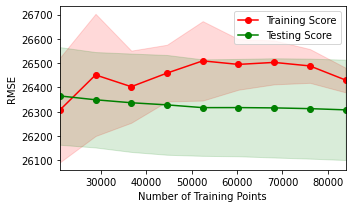

In [9]:
from sklearn.linear_model import LinearRegression

vs.modelLearning(LinearRegression(), cars_prepared, cars_labels)

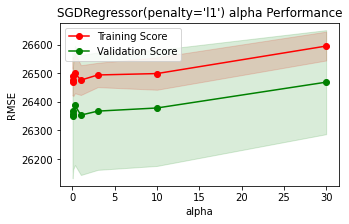

In [10]:
from sklearn.linear_model import SGDRegressor

# Lasso Regression learned using stochastic gradient descent (faster)
vs.modelParameter(SGDRegressor(penalty='l1'), 'alpha', [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30],
                  cars_prepared, cars_labels)

## Decision Tree Regressor

Model:  DecisionTreeRegressor()
RMSE(train_set):  219.04198034999922
RMSE(val_set):  20758.6769997897


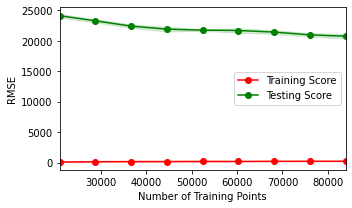

In [10]:
from sklearn.tree import DecisionTreeRegressor

vs.modelLearning(DecisionTreeRegressor(), cars_prepared, cars_labels)

Decision tree performed better than linear regression. Even for the validation set, the prediction results were better. It is likely that more complex tree-based models will give good prediction results.

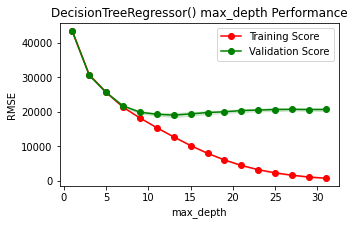

In [10]:
from sklearn.tree import DecisionTreeRegressor

vs.modelParameter(DecisionTreeRegressor(), 'max_depth', np.arange(1, 32, 2), cars_prepared, cars_labels)

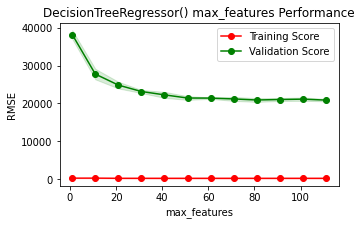

In [17]:
from sklearn.tree import DecisionTreeRegressor

vs.modelParameter(DecisionTreeRegressor(), 'max_features', np.arange(1, 115, 10), cars_prepared, cars_labels)

## Polynomial Regression
These models took a very long time to learn on the full dataset, so feature reduction was required. I did this by using Lasso regression with a large enough alpha coefficient. Due to the large dataset, I used stochastic gradient descent learning to make the learning process faster and less memory intensive.

In [10]:
from sklearn.linear_model import SGDRegressor

alphas = [0.1, 0.3, 1, 3, 10, 30, 100, 300, 1000, 3000, 10000, 30000]
zeroed_coef = []
for alpha in alphas:
    lasso = SGDRegressor(penalty='l1', alpha=alpha)
    lasso.fit(cars_prepared, cars_labels)
    zeroed_coef.append(sum(lasso.coef_ == 0))
    print('Alpha: ', alpha, 'Zeroed coef: ', sum(lasso.coef_ == 0), 'Left: ', 
          cars_prepared.shape[1] - sum(lasso.coef_ == 0))

Alpha:  0.1 Zeroed coef:  0 Left:  115
Alpha:  0.3 Zeroed coef:  1 Left:  114
Alpha:  1 Zeroed coef:  6 Left:  109
Alpha:  3 Zeroed coef:  7 Left:  108
Alpha:  10 Zeroed coef:  16 Left:  99
Alpha:  30 Zeroed coef:  41 Left:  74
Alpha:  100 Zeroed coef:  66 Left:  49
Alpha:  300 Zeroed coef:  82 Left:  33
Alpha:  1000 Zeroed coef:  101 Left:  14
Alpha:  3000 Zeroed coef:  104 Left:  11
Alpha:  10000 Zeroed coef:  111 Left:  4
Alpha:  30000 Zeroed coef:  113 Left:  2


In [9]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import SGDRegressor

# Transformation pipeline for polynomial regression
poly_regression = Pipeline([
    # Feature Selection using Lasso Regression
    ('feature_selection', SelectFromModel(SGDRegressor(penalty='l1'))),
    # Adding polynomial features
    ('poly_features', PolynomialFeatures(include_bias=False)),
    # Linear regression (SGD worked poorly with polynomials)
    ('lin_reg', LinearRegression())
])

poly_regression

Pipeline(steps=[('feature_selection',
                 SelectFromModel(estimator=SGDRegressor(penalty='l1'))),
                ('poly_features', PolynomialFeatures(include_bias=False)),
                ('lin_reg', LinearRegression())])

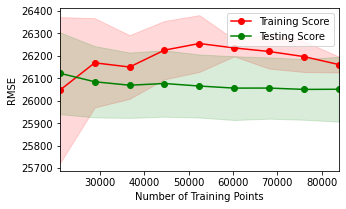

Model:  Pipeline(steps=[('feature_selection',
                 SelectFromModel(estimator=SGDRegressor(alpha=10000,
                                                        penalty='l1'))),
                ('poly_features', PolynomialFeatures(include_bias=False)),
                ('lin_reg', LinearRegression())])
RMSE(train_set):  26160.568625903998
RMSE(val_set):  26050.650987645502


In [10]:
poly_regression.set_params(feature_selection__estimator__alpha=10000, poly_features__degree=2)
vs.modelLearning(poly_regression, cars_prepared, cars_labels)

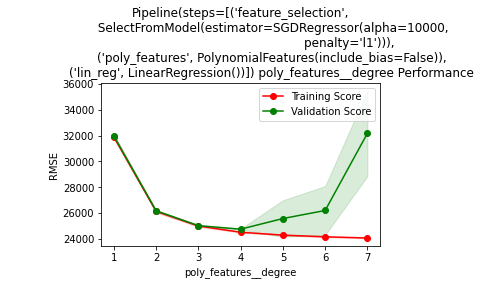

In [13]:
poly_regression.set_params(feature_selection__estimator__alpha=10000)
train_mean, test_mean = vs.modelParameter(poly_regression, 'poly_features__degree', 
                                          np.arange(1, 8), cars_prepared, cars_labels, 
                                          test_size=0.6, n_splits=3)
poly_10k_alpha = train_mean, test_mean

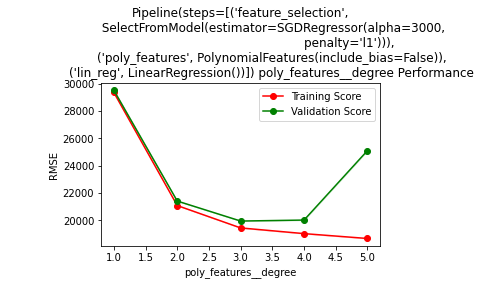

In [12]:
poly_regression.set_params(feature_selection__estimator__alpha=3000)
train_mean, test_mean = vs.modelParameter(poly_regression, 'poly_features__degree', 
                                          np.arange(1, 6), cars_prepared, cars_labels, 
                                          test_size=0.6, n_splits=1)
poly_3k_alpha = train_mean, test_mean

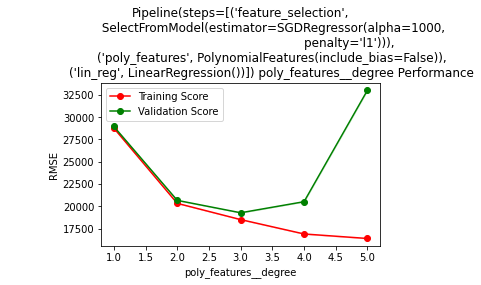

In [11]:
poly_regression.set_params(feature_selection__estimator__alpha=1000)
train_mean, test_mean = vs.modelParameter(poly_regression, 'poly_features__degree', 
                                          np.arange(1, 6), cars_prepared, cars_labels, 
                                          test_size=0.6, n_splits=1)
poly_1k_alpha = train_mean, test_mean

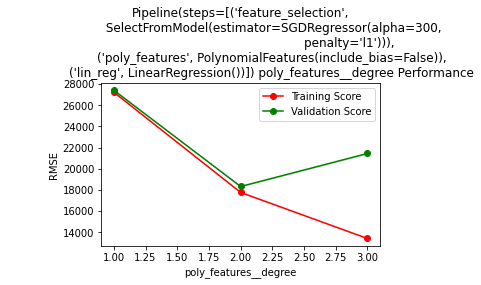

In [14]:
poly_regression.set_params(feature_selection__estimator__alpha=300)
train_mean, test_mean = vs.modelParameter(poly_regression, 'poly_features__degree', 
                                          np.arange(1, 4), cars_prepared, cars_labels, 
                                          test_size=0.6, n_splits=1)
poly_300_alpha = train_mean, test_mean

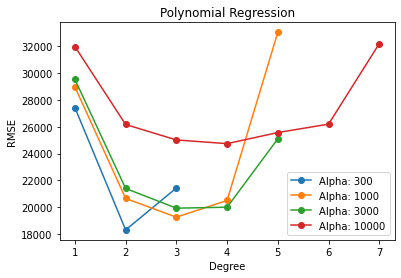

In [19]:
plt.plot(np.arange(1, 4), poly_300_alpha[1], 'o-', label='Alpha: 300')
plt.plot(np.arange(1, 6), poly_1k_alpha[1], 'o-', label='Alpha: 1000')
plt.plot(np.arange(1, 6), poly_3k_alpha[1], 'o-', label='Alpha: 3000')
plt.plot(np.arange(1, 8), poly_10k_alpha[1], 'o-', label='Alpha: 10000')
plt.title('Polynomial Regression')
plt.xlabel('Degree')
plt.ylabel('RMSE')
plt.legend()
plt.show()

### Conclusions:
With 14 features (alpha=1000), the RMSE for the validation set proved to be lower than for the decision tree. This method, however, was heavily time consuming and further increasing the number of features and polynomials was not possible due to excessive memory requirements.

# Random Forest Regressor

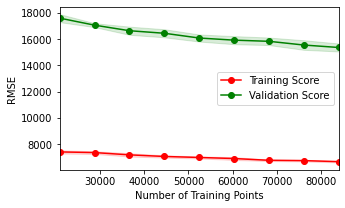

Model:  RandomForestRegressor(n_estimators=10, n_jobs=3)
RMSE(train_set):  6674.354322714949
RMSE(val_set):  15370.228561843145


In [10]:
from sklearn.ensemble import RandomForestRegressor

vs.modelLearning(RandomForestRegressor(n_estimators=10, n_jobs=3), cars_prepared, cars_labels)

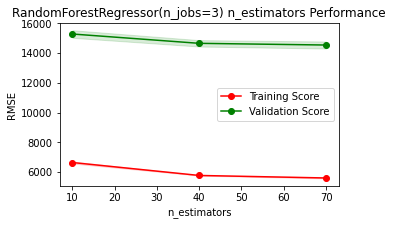

(array([6643.48985965, 5774.93559149, 5605.53222842]),
 array([15271.7720194 , 14646.09698177, 14532.01052445]))

In [11]:
from sklearn.ensemble import RandomForestRegressor

vs.modelParameter(RandomForestRegressor(n_jobs=3), 'n_estimators', np.arange(10, 100, 30), 
                  cars_prepared, cars_labels, n_splits=3)

### Conclusions
Random forests proved to be a good model for the given problem. The results were better than for polynomial regression. The learning time was also shorter.

## GradientBoostingRegressor 

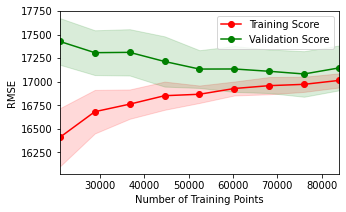

Model:  GradientBoostingRegressor()
RMSE(train_set):  17013.404130887113
RMSE(val_set):  17145.89956263742


In [13]:
from sklearn.ensemble import GradientBoostingRegressor

vs.modelLearning(GradientBoostingRegressor(), cars_prepared, cars_labels)

### Conclusions
GradientBoostingRegressor model with default hyperparameters generated worse prediction results than random forests. Its advantage was much shorter learning time.

## Adjusting the hyperparameters
Although random forests turned out to be the best model for auto price prediction, we decided to choose and tune the GradientBoostingRegressor model. The factor that decided in favor of this model is the much shorter learning time. This will allow us to perform more tests of different hyperparameters and thus improve the performance of the model.

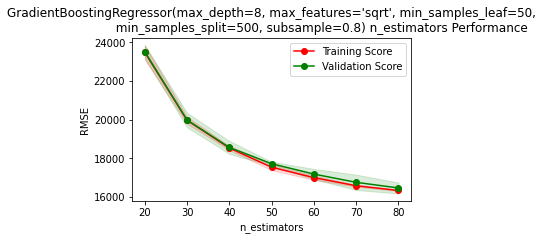

n_estimators 80
RMSE(train_set): 16325.191060996489
RMSE(val_set): 16455.136763847622


In [17]:
from sklearn.ensemble import GradientBoostingRegressor


param_name = 'n_estimators'
param_range = range(20, 81, 10)
train_mean, test_mean = vs.modelParameter(GradientBoostingRegressor(learning_rate=0.1, 
                                                                    min_samples_split=500, 
                                                                    min_samples_leaf=50, 
                                                                    max_depth=8, 
                                                                    max_features='sqrt', 
                                                                    subsample=0.8), 
                                          param_name, param_range, cars_prepared, cars_labels, n_splits=3)
print(param_name + ' ' + str(param_range[test_mean.tolist().index(min(test_mean))]))
print('RMSE(train_set): ' + str(train_mean[test_mean.tolist().index(min(test_mean))]))
print('RMSE(val_set): ' + str(min(test_mean)))

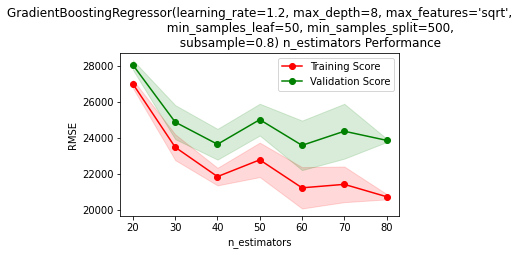

n_estimators 60
RMSE(train_set): 21210.748564735703
RMSE(val_set): 23573.153132702293


In [21]:
from sklearn.ensemble import GradientBoostingRegressor


param_name = 'n_estimators'
param_range = range(20, 81, 10)
train_mean, test_mean = vs.modelParameter(GradientBoostingRegressor(learning_rate=1.2, 
                                                                    min_samples_split=500, 
                                                                    min_samples_leaf=50, 
                                                                    max_depth=8, 
                                                                    max_features='sqrt', 
                                                                    subsample=0.8), 
                                          param_name, param_range, cars_prepared, cars_labels, n_splits=3)
print(param_name + ' ' + str(param_range[test_mean.tolist().index(min(test_mean))]))
print('RMSE(train_set): ' + str(train_mean[test_mean.tolist().index(min(test_mean))]))
print('RMSE(val_set): ' + str(min(test_mean)))

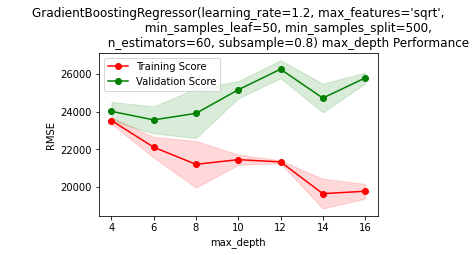

max_depth 6
RMSE(train_set): 22109.716033878984
RMSE(val_set): 23559.755323516398


In [23]:
from sklearn.ensemble import GradientBoostingRegressor


param_name = 'max_depth'
param_range = range(4, 17, 2)
train_mean, test_mean = vs.modelParameter(GradientBoostingRegressor(learning_rate=1.2, 
                                                                    n_estimators=60, 
                                                                    min_samples_split=500, 
                                                                    min_samples_leaf=50, 
                                                                    max_features='sqrt', 
                                                                    subsample=0.8), 
                                          param_name, param_range, cars_prepared, cars_labels, n_splits=3)
print(param_name + ' ' + str(param_range[test_mean.tolist().index(min(test_mean))]))
print('RMSE(train_set): ' + str(train_mean[test_mean.tolist().index(min(test_mean))]))
print('RMSE(val_set): ' + str(min(test_mean)))

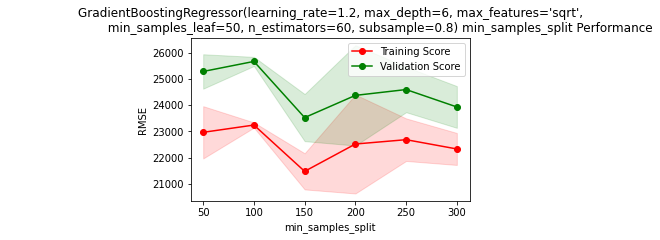

min_samples_split 150
RMSE(train_set): 21473.861993233073
RMSE(val_set): 23523.768664204385


In [24]:
from sklearn.ensemble import GradientBoostingRegressor


param_name = 'min_samples_split'
param_range = range(50, 301, 50)
train_mean, test_mean = vs.modelParameter(GradientBoostingRegressor(learning_rate=1.2, 
                                                                    n_estimators=60, 
                                                                    max_depth = 6, 
                                                                    min_samples_leaf=50, 
                                                                    max_features='sqrt', 
                                                                    subsample=0.8), 
                                          param_name, param_range, cars_prepared, cars_labels, n_splits=3)
print(param_name + ' ' + str(param_range[test_mean.tolist().index(min(test_mean))]))
print('RMSE(train_set): ' + str(train_mean[test_mean.tolist().index(min(test_mean))]))
print('RMSE(val_set): ' + str(min(test_mean)))

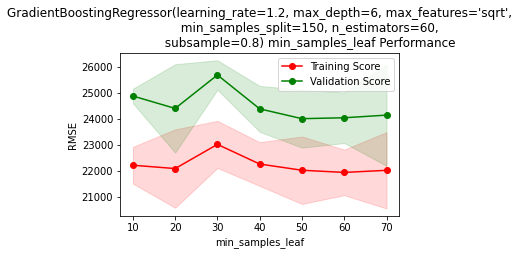

min_samples_leaf 50
RMSE(train_set): 22017.13209213104
RMSE(val_set): 24005.531381523197


In [25]:
from sklearn.ensemble import GradientBoostingRegressor


param_name = 'min_samples_leaf'
param_range = range(10, 71, 10)
train_mean, test_mean = vs.modelParameter(GradientBoostingRegressor(learning_rate=1.2, 
                                                                    n_estimators=60, 
                                                                    max_depth = 6, 
                                                                    min_samples_split = 150, 
                                                                    max_features='sqrt', 
                                                                    subsample=0.8), 
                                          param_name, param_range, cars_prepared, cars_labels, n_splits=3)
print(param_name + ' ' + str(param_range[test_mean.tolist().index(min(test_mean))]))
print('RMSE(train_set): ' + str(train_mean[test_mean.tolist().index(min(test_mean))]))
print('RMSE(val_set): ' + str(min(test_mean)))

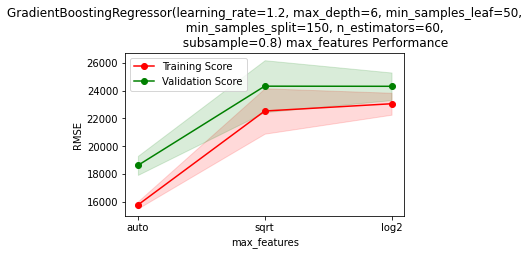

max_features auto
RMSE(train_set): 15766.198304101626
RMSE(val_set): 18616.28644868231


In [26]:
from sklearn.ensemble import GradientBoostingRegressor


param_name = 'max_features'
param_range = ['auto','sqrt','log2']
train_mean, test_mean = vs.modelParameter(GradientBoostingRegressor(learning_rate=1.2, 
                                                                    n_estimators=60, 
                                                                    max_depth = 6, 
                                                                    min_samples_split = 150, 
                                                                    min_samples_leaf = 50, 
                                                                    subsample=0.8), 
                                          param_name, param_range, cars_prepared, cars_labels, n_splits=3)
print(param_name + ' ' + str(param_range[test_mean.tolist().index(min(test_mean))]))
print('RMSE(train_set): ' + str(train_mean[test_mean.tolist().index(min(test_mean))]))
print('RMSE(val_set): ' + str(min(test_mean)))

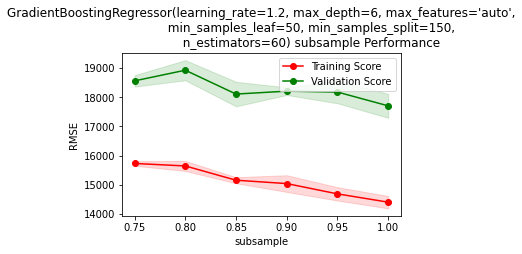

subsample 1
RMSE(train_set): 14400.633024498631
RMSE(val_set): 17702.86530313726


In [27]:
from sklearn.ensemble import GradientBoostingRegressor


param_name = 'subsample'
param_range = [0.75,0.8,0.85,0.9, 0.95, 1]
train_mean, test_mean = vs.modelParameter(GradientBoostingRegressor(learning_rate=1.2, 
                                                                    n_estimators=60, 
                                                                    max_depth = 6, 
                                                                    min_samples_split = 150, 
                                                                    min_samples_leaf = 50, 
                                                                    max_features = 'auto'), 
                                          param_name, param_range, cars_prepared, cars_labels, n_splits=3)
print(param_name + ' ' + str(param_range[test_mean.tolist().index(min(test_mean))]))
print('RMSE(train_set): ' + str(train_mean[test_mean.tolist().index(min(test_mean))]))
print('RMSE(val_set): ' + str(min(test_mean)))

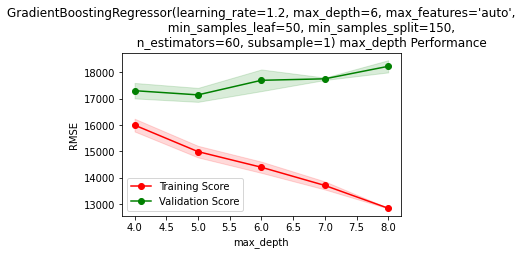

max_depth 5
RMSE(train_set): 14994.511528532019
RMSE(val_set): 17149.433436768475


In [28]:
from sklearn.ensemble import GradientBoostingRegressor


param_name = 'max_depth'
param_range = range(4, 9)
train_mean, test_mean = vs.modelParameter(GradientBoostingRegressor(learning_rate=1.2, 
                                                                    n_estimators=60, 
                                                                    max_depth = 6, 
                                                                    min_samples_split = 150, 
                                                                    min_samples_leaf = 50, 
                                                                    max_features = 'auto', 
                                                                    subsample = 1), 
                                          param_name, param_range, cars_prepared, cars_labels, n_splits=3)
print(param_name + ' ' + str(param_range[test_mean.tolist().index(min(test_mean))]))
print('RMSE(train_set): ' + str(train_mean[test_mean.tolist().index(min(test_mean))]))
print('RMSE(val_set): ' + str(min(test_mean)))

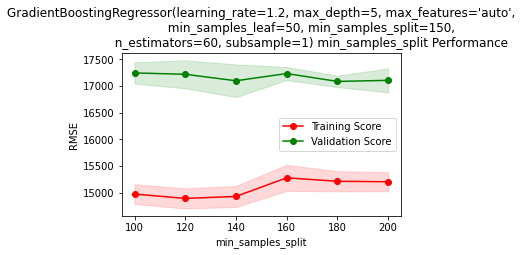

min_samples_split 180
RMSE(train_set): 15212.000208066951
RMSE(val_set): 17083.641722061428


In [29]:
from sklearn.ensemble import GradientBoostingRegressor


param_name = 'min_samples_split'
param_range = range(100, 201, 20)
train_mean, test_mean = vs.modelParameter(GradientBoostingRegressor(learning_rate=1.2, 
                                                                    n_estimators=60, 
                                                                    max_depth = 5, 
                                                                    min_samples_split = 150, 
                                                                    min_samples_leaf = 50, 
                                                                    max_features = 'auto', 
                                                                    subsample = 1), 
                                          param_name, param_range, cars_prepared, cars_labels, n_splits=3)
print(param_name + ' ' + str(param_range[test_mean.tolist().index(min(test_mean))]))
print('RMSE(train_set): ' + str(train_mean[test_mean.tolist().index(min(test_mean))]))
print('RMSE(val_set): ' + str(min(test_mean)))

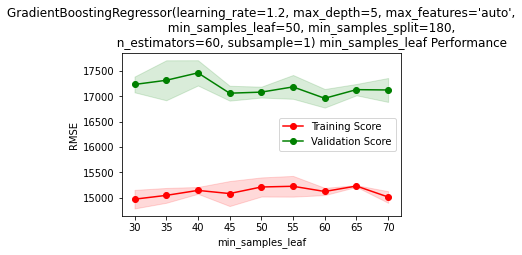

min_samples_leaf 60
RMSE(train_set): 15123.351642168347
RMSE(val_set): 16961.824693895393


In [30]:
from sklearn.ensemble import GradientBoostingRegressor


param_name = 'min_samples_leaf'
param_range = range(30, 71, 5)
train_mean, test_mean = vs.modelParameter(GradientBoostingRegressor(learning_rate=1.2, 
                                                                    n_estimators=60, 
                                                                    max_depth = 5, 
                                                                    min_samples_split = 180, 
                                                                    min_samples_leaf = 50, 
                                                                    max_features = 'auto', 
                                                                    subsample = 1), 
                                          param_name, param_range, cars_prepared, cars_labels, n_splits=3)
print(param_name + ' ' + str(param_range[test_mean.tolist().index(min(test_mean))]))
print('RMSE(train_set): ' + str(train_mean[test_mean.tolist().index(min(test_mean))]))
print('RMSE(val_set): ' + str(min(test_mean)))

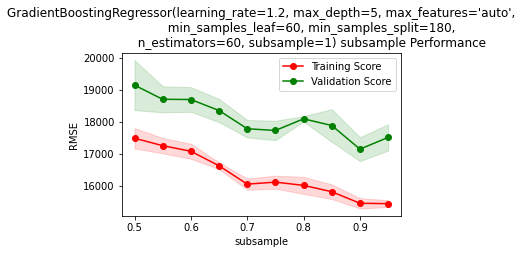

subsample 0.9000000000000004
RMSE(train_set): 15454.345568378138
RMSE(val_set): 17146.269876119313


In [38]:
from sklearn.ensemble import GradientBoostingRegressor


param_name = 'subsample'
param_range = np.arange(0.5, 1.05, 0.05)
train_mean, test_mean = vs.modelParameter(GradientBoostingRegressor(learning_rate=1.2, 
                                                                    n_estimators=60, 
                                                                    max_depth = 5, 
                                                                    min_samples_split = 180, 
                                                                    min_samples_leaf = 60, 
                                                                    max_features = 'auto', 
                                                                    subsample = 1), 
                                          param_name, param_range, cars_prepared, cars_labels, n_splits=3)
print(param_name + ' ' + str(param_range[test_mean.tolist().index(min(test_mean))]))
print('RMSE(train_set): ' + str(train_mean[test_mean.tolist().index(min(test_mean))]))
print('RMSE(val_set): ' + str(min(test_mean)))

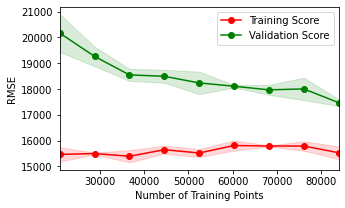

Model:  GradientBoostingRegressor(learning_rate=1.2, max_depth=5, max_features='auto',
                          min_samples_leaf=60, min_samples_split=180,
                          n_estimators=60, subsample=0.9)
RMSE(train_set):  15530.080441869628
RMSE(val_set):  17471.6813158489


In [40]:
from sklearn.ensemble import GradientBoostingRegressor

vs.modelLearning(GradientBoostingRegressor(learning_rate=1.2, n_estimators=60, max_depth = 5, 
                                           min_samples_split = 180, min_samples_leaf = 60, 
                                           max_features = 'auto', subsample = 0.9), 
                 cars_prepared, cars_labels, n_splits = 3)

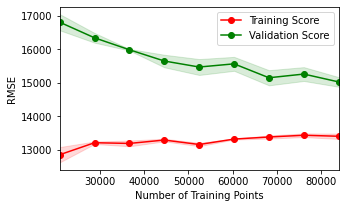

Model:  GradientBoostingRegressor(learning_rate=0.6, max_depth=5, max_features='auto',
                          min_samples_leaf=60, min_samples_split=180,
                          n_estimators=120, subsample=0.9)
RMSE(train_set):  13406.648313099291
RMSE(val_set):  15029.41810596948


In [41]:
from sklearn.ensemble import GradientBoostingRegressor

vs.modelLearning(GradientBoostingRegressor(learning_rate=0.6, n_estimators=120, max_depth = 5, 
                                           min_samples_split = 180, min_samples_leaf = 60, 
                                           max_features = 'auto', subsample = 0.9), 
                 cars_prepared, cars_labels, n_splits = 3)

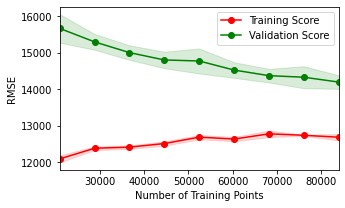

Model:  GradientBoostingRegressor(learning_rate=0.3, max_depth=5, max_features='auto',
                          min_samples_leaf=60, min_samples_split=180,
                          n_estimators=240, subsample=0.9)
RMSE(train_set):  12681.778849869195
RMSE(val_set):  14191.996398476958


In [42]:
from sklearn.ensemble import GradientBoostingRegressor

vs.modelLearning(GradientBoostingRegressor(learning_rate=0.3, n_estimators=240, max_depth = 5, 
                                           min_samples_split = 180, min_samples_leaf = 60, 
                                           max_features = 'auto', subsample = 0.9), 
                 cars_prepared, cars_labels, n_splits = 3)

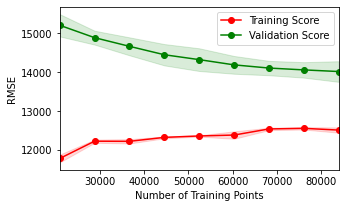

Model:  GradientBoostingRegressor(learning_rate=0.15, max_depth=5, max_features='auto',
                          min_samples_leaf=60, min_samples_split=180,
                          n_estimators=480, subsample=0.9)
RMSE(train_set):  12511.742407934129
RMSE(val_set):  14018.178999216476


In [43]:
from sklearn.ensemble import GradientBoostingRegressor

vs.modelLearning(GradientBoostingRegressor(learning_rate=0.15, n_estimators=480, max_depth = 5, 
                                           min_samples_split = 180, min_samples_leaf = 60, 
                                           max_features = 'auto', subsample = 0.9), 
                 cars_prepared, cars_labels, n_splits = 3)

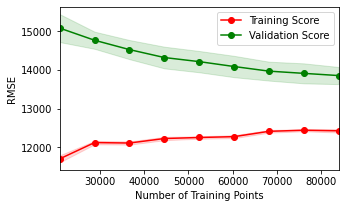

Model:  GradientBoostingRegressor(learning_rate=0.075, max_depth=5, max_features='auto',
                          min_samples_leaf=60, min_samples_split=180,
                          n_estimators=960, subsample=0.9)
RMSE(train_set):  12424.314789989343
RMSE(val_set):  13855.98040730982


In [44]:
from sklearn.ensemble import GradientBoostingRegressor

vs.modelLearning(GradientBoostingRegressor(learning_rate=0.075, n_estimators=960, max_depth = 5, 
                                           min_samples_split = 180, min_samples_leaf = 60, 
                                           max_features = 'auto', subsample = 0.9), 
                 cars_prepared, cars_labels, n_splits = 3)

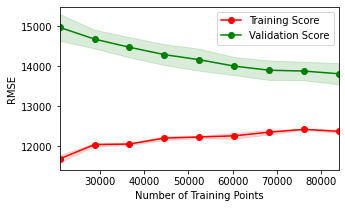

Model:  GradientBoostingRegressor(learning_rate=0.0375, max_depth=5,
                          max_features='auto', min_samples_leaf=60,
                          min_samples_split=180, n_estimators=1920,
                          subsample=0.9)
RMSE(train_set):  12370.63720723658
RMSE(val_set):  13811.847142557774


In [45]:
from sklearn.ensemble import GradientBoostingRegressor

vs.modelLearning(GradientBoostingRegressor(learning_rate=0.0375, n_estimators=1920, max_depth = 5, 
                                           min_samples_split = 180, min_samples_leaf = 60, 
                                           max_features = 'auto', subsample = 0.9), 
                 cars_prepared, cars_labels, n_splits = 3)

### Conclusions
The best model was the Gradient Boosting Regressor with the following hyperparameters:
- learning rate (learning_rate): 0.0375
- number of estimators (n_estimators): 1920
- maximum number of features considered when looking for the best node split (max_features): 'auto' (no limit/all)
- minimum number of samples per leaf (min_samples_leaf): 60
- minimum number of samples to split a node (min_samples_split): 180
- maximum depth of a single estimator (max_depth): 5
- fraction of the learning set used to learn a single estimator (subsample): 0.9


# Model testing
Let's test the model on the training set (previously we did this on a smaller validation set and fitted hyperparameters to it)

In [10]:
cars_test = test_set.drop('Cena', axis=1).reset_index(drop=True)
cars_labels_test = test_set['Cena'].copy().reset_index(drop=True)

In [12]:
from sklearn.ensemble import GradientBoostingRegressor

final_model = GradientBoostingRegressor(learning_rate=0.0375, n_estimators=1920, max_depth = 5, 
                                        min_samples_split = 180, min_samples_leaf = 60, 
                                        max_features = 'auto', subsample = 0.9)
final_model.fit(cars_prepared, cars_labels)

GradientBoostingRegressor(learning_rate=0.0375, max_depth=5,
                          max_features='auto', min_samples_leaf=60,
                          min_samples_split=180, n_estimators=1920,
                          subsample=0.9)

In [13]:
# A transformation pipeline consisting of a preprocessor and a regressor 
# (we will be able to handle raw data with one pipeline)
final_pipeline = Pipeline(steps=[
    ('preprocessing', full_pipeline),
    ('regressor', final_model)
])
final_pipeline

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['Rok produkcji', 'Przebieg',
                                                   'Pojemność skokowa', 'Moc',
                                                   'Sz. geograficzna',
                                                   'Dł. geograficzna',
                                                   'Liczba drzwi',
                                                   'Liczba miejsc',
                                                   'Możliwość finansowania',
                                                   'Zarejestrowany w Polsce',
                                                   'Pierwszy wł...
                                                                   RareToOther(model_threshold=0.1)),
                                                                  ('encoder',
                                                                   OneHotEncoder())]),
                                                  ['Oferta od', 'Marka pojazdu',
                                                   'Model pojazdu',
                                                   'Rodzaj paliwa',
                                                   'Skrzynia biegów', 'Napęd',
                                                   'Typ nadwozia', 'Kolor',
                                                   'Rodzaj koloru', 'Stan',
                                                   'Kraj pochodzenia'])])),
                ('regressor',
                 GradientBoostingRegressor(learning_rate=0.0375, max_depth=5,
                                           max_features='auto',
                                           min_samples_leaf=60,
                                           min_samples_split=180,
                                           n_estimators=1920, subsample=0.9))])

In [14]:
import joblib

# saving the trained model
joblib.dump(final_pipeline, 'final_model.pkl')

['final_model.pkl']

In [15]:
# Loading a previously trained model
final_model = joblib.load('final_model.pkl')
final_model

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['Rok produkcji', 'Przebieg',
                                                   'Pojemność skokowa', 'Moc',
                                                   'Sz. geograficzna',
                                                   'Dł. geograficzna',
                                                   'Liczba drzwi',
                                                   'Liczba miejsc',
                                                   'Możliwość finansowania',
                                                   'Zarejestrowany w Polsce',
                                                   'Pierwszy wł...
                                                                   RareToOther(model_threshold=0.1)),
                                                                  ('encoder',
                                                                   OneHotEncoder())]),
                                                  ['Oferta od', 'Marka pojazdu',
                                                   'Model pojazdu',
                                                   'Rodzaj paliwa',
                                                   'Skrzynia biegów', 'Napęd',
                                                   'Typ nadwozia', 'Kolor',
                                                   'Rodzaj koloru', 'Stan',
                                                   'Kraj pochodzenia'])])),
                ('regressor',
                 GradientBoostingRegressor(learning_rate=0.0375, max_depth=5,
                                           max_features='auto',
                                           min_samples_leaf=60,
                                           min_samples_split=180,
                                           n_estimators=1920, subsample=0.9))])

In [19]:
cars_train_predictions = final_model.predict(cars)
mse = mean_squared_error(cars_labels, cars_train_predictions)
rmse = np.sqrt(mse)
print('Model: ', final_model)
print('RMSE(train_set): ', rmse)
cars_test_predictions = final_model.predict(cars_test)
mse = mean_squared_error(cars_labels_test, cars_test_predictions)
rmse = np.sqrt(mse)
print('RMSE(test_set): ', rmse)

Model:  Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['Rok produkcji', 'Przebieg',
                                                   'Pojemność skokowa', 'Moc',
                                                   'Sz. geograficzna',
                                                   'Dł. geograficzna',
                                                   'Liczba drzwi',
                                                   'Liczba miejsc',
                                                   'Możliwość finansowania',
                                

## Conclusions
The RMSE for the test set was: 13958. This is a satisfactory result considering the limited computational resources and time.

## Feature importances

In [27]:
features = numerical_columns + categorical_columns
feature_importances = list(zip(features, final_model.named_steps['regressor'].feature_importances_))

In [30]:
feature_importances_df = pd.DataFrame(feature_importances, columns=['Feature', 'Importance']).set_index('Feature')
feature_importances_df['Importance'] = feature_importances_df['Importance'].astype(float)
feature_importances_df = feature_importances_df.sort_values(by=['Importance'], ascending=False)

<AxesSubplot:title={'center':'Feature importances (TOP 20)'}, ylabel='Feature'>

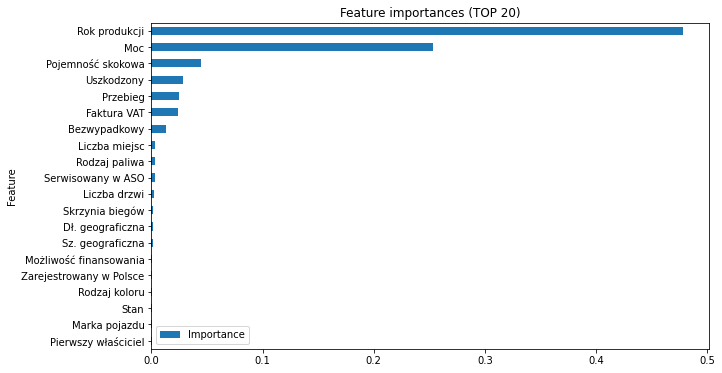

In [38]:
feature_importances_df.head(20).sort_values(by=['Importance']).plot(kind='barh',
                                                                   figsize=(10, 6),
                                                                   title='Feature importances (TOP 20)')

### Conclusions
Two features definitely affect price more than others. These are: Year of production and Power. This seems logical since younger and more powerful cars tend to be more expensive.  The features "Damaged" and "No Accident" have a high utility factor, fully operational cars are worth more. The high position of "VAT invoice" feature is influenced by the fact that they are usually listed by car dealers, which increases the price of the car. Geographical coordinates are also among the most prominent features. The location of the sale affects the price of the car.

## Prediction accuracy across price ranges
Let's see how our model performs in predicting the price in each price range

In [40]:
# Divide the test set into 10 equal (similar number of samples) price ranges
test_set_grouped = test_set.copy()
test_set_grouped['Grupa cenowa'] = pd.qcut(test_set_grouped['Cena'], q=20)
price_groups = test_set_grouped['Grupa cenowa'].value_counts(sort=False)
price_groups

(3699.999, 8294.1]      1311
(8294.1, 11000.0]       1324
(11000.0, 13900.0]      1394
(13900.0, 16500.0]      1289
(16500.0, 18900.0]      1375
(18900.0, 21700.0]      1188
(21700.0, 24500.0]      1323
(24500.0, 27500.0]      1340
(27500.0, 30900.0]      1278
(30900.0, 35500.0]      1298
(35500.0, 39900.0]      1469
(39900.0, 45000.0]      1189
(45000.0, 51500.0]      1272
(51500.0, 58900.0]      1332
(58900.0, 67900.0]      1339
(67900.0, 78900.0]      1276
(78900.0, 92900.0]      1316
(92900.0, 119900.0]     1318
(119900.0, 167810.0]    1277
(167810.0, 384900.0]    1311
Name: Grupa cenowa, dtype: int64

In [42]:
median = []
MAE = []
mean_error_coef = []
for group in price_groups.index:
    dataset = test_set_grouped[test_set_grouped['Grupa cenowa'] == group]
    X = dataset.drop(['Cena', 'Grupa cenowa'], axis=1)
    y = dataset['Cena'].copy()
    predictions = final_model.predict(X)
    median.append(y.median())
    MAE.append(abs(y - predictions).mean())
    mean_error_coef.append(abs((y - predictions) / y).mean())
    print(group, abs(y - predictions).mean(), y.median(), abs((y - predictions) / y).mean())

(3699.999, 8294.1] 3241.5370475344002 6500.0 0.5410269573224938
(8294.1, 11000.0] 3067.8356357465177 9900.0 0.31824145021073047
(11000.0, 13900.0] 3094.488808340254 12900.0 0.2449979079722453
(13900.0, 16500.0] 3224.165658568503 15400.0 0.21127981404433444
(16500.0, 18900.0] 3144.460184774623 17900.0 0.1761737147743262
(18900.0, 21700.0] 3588.4339360175873 19900.0 0.17805812712450053
(21700.0, 24500.0] 3866.7217795209576 22900.0 0.16777665338666928
(24500.0, 27500.0] 4060.737466024312 25900.0 0.15670847517318479
(27500.0, 30900.0] 4658.901152315808 29000.0 0.15975858905604629
(30900.0, 35500.0] 4952.699687602542 33333.0 0.14851489231126316
(35500.0, 39900.0] 5261.842181035119 37900.0 0.13844026520556546
(39900.0, 45000.0] 5739.18983508551 42900.0 0.13388840799831758
(45000.0, 51500.0] 6723.764089182479 48900.0 0.1385199637108055
(51500.0, 58900.0] 6912.495316650705 55000.0 0.12523228837869438
(58900.0, 67900.0] 7592.760270305968 63490.0 0.12017172532535567
(67900.0, 78900.0] 8691.30270

In [46]:
# Errors for individual price groups
grouped_error_df = pd.DataFrame(np.array([price_groups.index, MAE, median, mean_error_coef]).T, 
                                columns = ['Price range', 'Mean Absolute Error', 
                                           'Median', 'Average ratio of error to actual price'])
grouped_error_df

,Price range,Mean Absolute Error,Median,Average ratio of error to actual price
0,"(3699.999, 8294.1]",3241.537048,6500.0,0.541027
1,"(8294.1, 11000.0]",3067.835636,9900.0,0.318241
2,"(11000.0, 13900.0]",3094.488808,12900.0,0.244998
3,"(13900.0, 16500.0]",3224.165659,15400.0,0.21128
4,"(16500.0, 18900.0]",3144.460185,17900.0,0.176174
5,"(18900.0, 21700.0]",3588.433936,19900.0,0.178058
6,"(21700.0, 24500.0]",3866.72178,22900.0,0.167777
7,"(24500.0, 27500.0]",4060.737466,25900.0,0.156708
8,"(27500.0, 30900.0]",4658.901152,29000.0,0.159759
9,"(30900.0, 35500.0]",4952.699688,33333.0,0.148515


<AxesSubplot:xlabel='Median'>

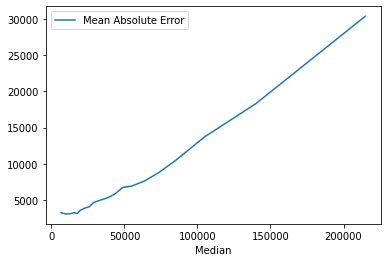

In [44]:
grouped_error_df.plot(x='Median', y='Mean Absolute Error')

<AxesSubplot:xlabel='Median'>

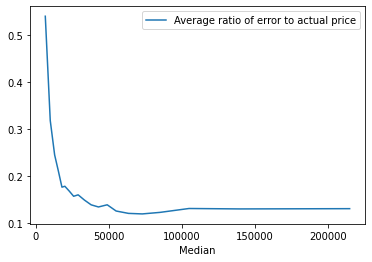

In [45]:
grouped_error_df.plot(x='Median', y='Average ratio of error to actual price')

### Conclusions
Our model performs poorly on advertisements with a price below 10K PLN. The error then often exceeds 50% of the actual value. As the price increases, this ratio decreases and for vehicles in the 10k-20k PLN range is around 15-20%. For more expensive cars (over 50k PLN) the error oscillates around 13% of the actual price.